# Mini-projet Apache Spark

Merci d'indiquer les noms composant le binôme :

|Nom | Prénom|
|---|---|
| <font color='red'>  PINTO | <font color='red'>  Antoine |

L'objectif est de collecter les données de validations quotidiennes de titres de transport de la région parisienne, disponibles en Open Data sur le site de Mobilités Ile-de-France.

On se concentrera sur le **réseau ferré** exclusivement pour cet exercice.

## Installation de Spark

Apache Spark n'est pas disponible en standard sur Google Colab.
Procéder à son installation, ainsi qu'à son initialisation pour réaliser le traitement à venir.

In [ ]:
!pip install pyspark
import pyspark
spark = pyspark.sql.SparkSession.builder.appName('First One').getOrCreate()
spark

     |████████████████████████████████| 281.3 MB 35 kB/s 
     |████████████████████████████████| 198 kB 62.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=44cf7af9b004aba886bec9aa08da9b836f1715cf90454911b813340e68d3cc59
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


## Récupération des données

Sur le site https://data.iledefrance-mobilites.fr, récupérer les données de validation par jour.

Exemple :
https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/information/

Récupérer les données de S1 2020 et S2 2021 pour disposer d'une année complète.

On utilisera pour ce faire les commandes de téléchargement de fichiers depuis un site (pas de chargement manuel).

__Attention__ : prévoir une vingtaine de minutes pour le téléchargement, au moins une première fois, et donc une copie sur Google Drive si Google Colab est utilisée, afin d'éviter ce temps d'attente lors de sessions de travail successives.

In [ ]:
!curl -o data1.csv https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/download/?format=csv
!curl -o data2.csv https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.3M    0 47.3M    0     0  48585      0 --:--:--  0:17:00 --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M    0 24.7M    0     0  73122      0 --:--:--  0:05:54 --:--:--  101k


### Commentaires sur les données disponibles sur ce portail

Investiguer les données diponibles sur le portail.

Question : peut-on constituer un historique de données s'étendant sur les trois dernières années (2019 à 2021) ?


🔽
<font color='red'>***Sur le portail, des données sont disponibles de 2015 à 2019 depuis ce lien : https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations/information/.***

<font color='red'>***Cependant, les données du second semestre 2019 et du premier semestre 2020 ne semblent pas disponibles.***

## Lecture des fichiers dans Spark

Lire les fichiers en choisissant les bonnes options de lecture.
Concaténer les données en une seule table.

In [ ]:
df1 = spark.read.csv('data1.csv', sep=';')
df2 = spark.read.csv('data2.csv', sep=';')

df1.show(5)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive')

df1 = (spark.read.csv('/content/gdrive/MyDrive/Projet Outils du Big Data/data1.csv', sep=';', inferSchema=True, header = True))
df2 = (spark.read.csv('/content/gdrive/MyDrive/Projet Outils du Big Data/data2.csv', sep=';', inferSchema=True, header = True))

df1.show(5)

Mounted at /content/gdrive
+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|      libelle_arret|id_refa_lda|categorie_titre|   nb_vald|
+----------+--------------+-------------+---------------+-------------------+-----------+---------------+----------+
|2020-07-11|           800|          822|            222|             GARGAN|          ?|      IMAGINE R|        24|
|2020-07-11|           800|          822|            222|             GARGAN|          ?|         NAVIGO|       102|
|2020-07-11|           800|          822|            222|             GARGAN|          ?|     NON DEFINI|Moins de 5|
|2020-07-11|           800|          822|            224|              BONDY|          ?|      AMETHYSTE|Moins de 5|
|2020-07-11|           800|          850|            140|CHAMPBENOIST-POIGNY|      62064|         NAVIGO|        38|
+----------+--------------+----------

<font color='red'>***Concaténation des deux fichiers :***

In [ ]:
validations_ddf = df1.unionByName(df2)

## Validation

Si vous avez appelé votre dataframe `validations_ddf`, le test suivant ne doit pas générer d'erreur.

<font color='red'>***Le nombre de lignes correspond***

In [ ]:
validations_ddf.count()

1316287

In [ ]:
assert validations_ddf.count() == 1_316_287, "Le nombre de lignes ne correspond pas"

Dans le cas où ce code génère une erreur, il s'agit probablement d'un problème de récupération ou de lecture des deux fichiers.

## Préparation des données

Réaliser les transformations nécessaires pour exploiter ces données :
- préparation des dates
- transformation du nombre de validation

### Explication pour le nombre de validations

Analyser les valeurs prises par ce champ et déterminer le problème.
Présenter votre stratégie pour remédier à ce choix de codage par Mobilités Ile-de-France.

In [ ]:
import pyspark.sql.functions as F

<font color='red'>***Tri des dates de la plus ancienne à la plus récente :***

In [ ]:
validations_ddf = validations_ddf.sort('jour')
validations_ddf.show(5)

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|       libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|              ?|     99|
|2020-07-01|           100|          110|            100|BOULOGNE-PONT DE ...|      70721|    NAVIGO JOUR|      5|
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|    NAVIGO JOUR|     11|
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|     NON DEFINI|    270|
|2020-07-01|           100|          110|             10|              ALESIA|      71030|              ?|     29|
+----------+--------------+-------------+---------------+--------------------+--

<font color='red'>***Il y a 140 672 observations pour lesquelles la variable 'nb_vald' prend la valeur "Moins de 5".***

In [ ]:
validations_ddf.filter(F.col('nb_vald') == "Moins de 5").count()

140672

<font color='red'>***Il est rare que cette occurence apparaisse pour les titre NAVIGO et IMAGINE R***

In [ ]:
(validations_ddf
 .filter(F.col('nb_vald') == "Moins de 5")
 .groupby('categorie_titre')
 .agg(F.count('nb_vald').alias('Nb occurence "Moins de 5"'))).show()

+---------------+-------------------------+
|categorie_titre|Nb occurence "Moins de 5"|
+---------------+-------------------------+
|         NAVIGO|                     1999|
|     NON DEFINI|                    12662|
|      IMAGINE R|                     3910|
|            FGT|                     9522|
|    NAVIGO JOUR|                    64020|
|    AUTRE TITRE|                    10163|
|              ?|                    15936|
|            TST|                     9230|
|      AMETHYSTE|                    13230|
+---------------+-------------------------+



<font color='red'>***Je décide de remplacer les "Moins de 5" par la valeur 2.***

In [ ]:
validations_ddf = validations_ddf.withColumn('nb_vald', F.when(F.col('nb_vald') != "Moins de 5", F.col('nb_vald')).otherwise("2"))
validations_ddf.show(5)

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|       libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|              ?|     99|
|2020-07-01|           100|          110|            100|BOULOGNE-PONT DE ...|      70721|    NAVIGO JOUR|      5|
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|    NAVIGO JOUR|     11|
|2020-07-01|           100|          110|              1|       PORTE MAILLOT|      71379|     NON DEFINI|    270|
|2020-07-01|           100|          110|             10|              ALESIA|      71030|              ?|     29|
+----------+--------------+-------------+---------------+--------------------+--

<font color='red'>***Je peux désormais convertir la variable nb_vald en integer (elle était précédemment en string)***

In [ ]:
validations_ddf = validations_ddf.withColumn("nb_vald", validations_ddf.nb_vald.cast('int'))

## Détermination des principales catégories de titre

Différentes catégories de titre sont utilisées sur le réseau.

Déterminer les deux catégories principalement utilisées. Seules ces catégories seront utilisées dans les travaux ci-après (les utiliser comme filtre sur les validations dans la suite).

<font color='red'>***Le tableau suivant montre que les catégories NAVIGO et IMAGINE R sont les principales utilisées : NAVIGO représente 59% des validations alors que IMAGINE R en représente 17%***

In [ ]:
from pyspark.sql.functions import concat, col, lit
from pyspark.sql.window import Window

(validations_ddf
 .groupby('categorie_titre')
 .agg(F.sum('nb_vald').alias('Total_Validation'))
 .withColumn('Proportion',concat(F.round(F.col('Total_Validation')/F.sum('Total_Validation').over(Window.partitionBy())*100, 1), lit(" %")))).show()

+---------------+----------------+----------+
|categorie_titre|Total_Validation|Proportion|
+---------------+----------------+----------+
|         NAVIGO|       381577998|    58.9 %|
|     NON DEFINI|        32683938|     5.0 %|
|      IMAGINE R|       111250367|    17.2 %|
|            FGT|        27872115|     4.3 %|
|    NAVIGO JOUR|          917396|     0.1 %|
|    AUTRE TITRE|        20019743|     3.1 %|
|              ?|         8425969|     1.3 %|
|            TST|        46087673|     7.1 %|
|      AMETHYSTE|        18851932|     2.9 %|
+---------------+----------------+----------+



<font color='red'>***Je ne garde que les observations correspondantes aux deux catégories principalement utilisées***

In [ ]:
validations_ddf = validations_ddf.filter((F.col('categorie_titre') == "NAVIGO") | (F.col('categorie_titre') == "IMAGINE R"))
validations_ddf.show(10)

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|       libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+
|2020-07-01|           100|          110|           1006|          OLYMPIADES|      71557|      IMAGINE R|   2006|
|2020-07-01|           100|          110|              2|            ABBESSES|      71432|         NAVIGO|   1042|
|2020-07-01|           100|          110|           1007|LES AGNETTES-ASNI...|      72240|      IMAGINE R|    508|
|2020-07-01|           100|          110|           1073|       FR. POPULAIRE|      74041|      IMAGINE R|    815|
|2020-07-01|           100|          110|            120|     BUTTES-CHAUMONT|      71900|         NAVIGO|    346|
|2020-07-01|           100|          110|            144|CHAMPS-ELYSEES-CL...|  

## Visualisation du trafic dans une station

Visualiser le trafic à la gare de Lyon pour les deux catégories de titre principales.

Attention à gérer le cas des gares (comme la gare de Lyon) présentes sur plusieurs lignes et dont le libellé apparaît donc sur plusieurs lignes. Investiguer ce cas avant de déterminer la bonne façon de calculer le nombre de validations pour la gare de Lyon.

<font color='red'>***On observe que différentes lignes sont présentes à la Gare de Lyon. : elles correspondent aux codes stif 306, 307 et 317*** 

In [ ]:
validations_ddf.filter(F.col('libelle_arret') == "GARE DE LYON").show(5)

+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|2020-07-01|           800|          804|            307| GARE DE LYON|      73626|      IMAGINE R|    509|
|2020-07-01|           100|          110|            317| GARE DE LYON|      73626|      IMAGINE R|   2115|
|2020-07-01|           100|          110|            317| GARE DE LYON|      73626|         NAVIGO|   9001|
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|         NAVIGO|   8545|
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|      IMAGINE R|   2288|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
only showing top 5 rows



In [ ]:
(validations_ddf
 .filter(F.col('libelle_arret') == "GARE DE LYON")
 .groupby('code_stif_arret')
 .agg(F.sum('nb_vald').alias('Total_Validation'))).show()

+---------------+----------------+
|code_stif_arret|Total_Validation|
+---------------+----------------+
|            307|          415520|
|            317|         2874070|
|            306|         2826705|
+---------------+----------------+



<font color='red'>***En visualisant le nombre de validations par jour selon le type de titre, on observe l'effet du reconfinement de fin octobre 2020.***

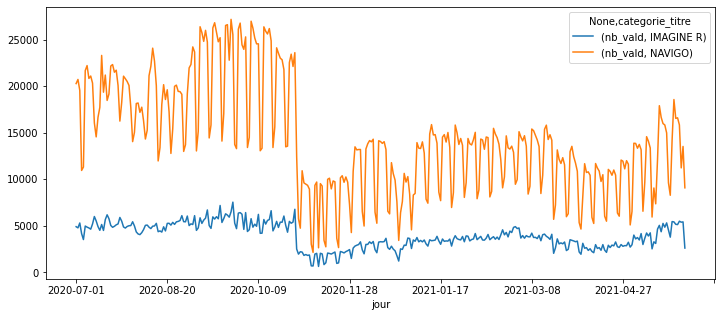

In [ ]:
import seaborn as sns

(validations_ddf
    .filter(F.col('libelle_arret') == "GARE DE LYON")
    .groupby('jour', 'categorie_titre')
    .agg(F.sum('nb_vald').alias('nb_vald'))).toPandas().set_index(['jour', 'categorie_titre']).unstack(1).plot(figsize=(12, 5))

<font color='red'>***Voici le même graphique en utilisant une moyenne mobile sur les 7 derniers jours :***

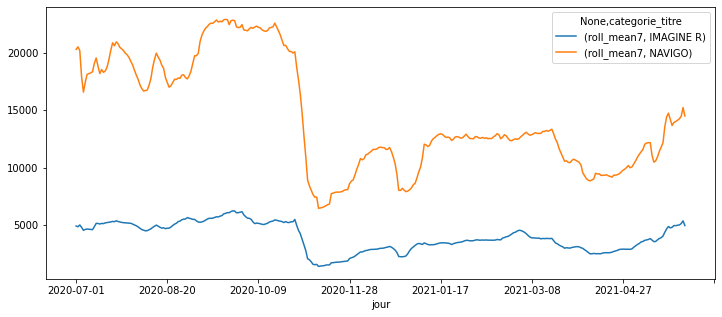

In [ ]:
agg_window = Window.partitionBy('categorie_titre').orderBy('jour').rowsBetween(-6,0)

(validations_ddf
 .filter(F.col('libelle_arret') == "GARE DE LYON")
 .groupby('jour', 'categorie_titre')
 .agg(F.sum('nb_vald').alias('nb_vald'))
 .withColumn('roll_mean7', F.mean('nb_vald').over(agg_window))
 .select('jour', 'categorie_titre', 'roll_mean7')).toPandas().set_index(['jour', 'categorie_titre']).unstack(1).plot(figsize=(12, 5))


## Fluctuation du trafic hebdomadaire

Calculer le trafic total et le pourcentage par jour de la semaine sur l'ensemble du réseau.

Trier le résultat par ordre décroissant de validations.

Note : considérer l'usage d'une fonction analytique (`Window.partitionBy()`).


<font color='red'>***Le tableau suivant donne le trafic total et son pourcentage par jour de la semaine. On remarque logiquement que le trafic est plus faible le samedi (7) et dimanche (1).***

In [ ]:
(validations_ddf
 .withColumn('day_week', F.dayofweek('jour'))
 .groupby('day_week')
 .agg(F.sum('nb_vald').alias('Total_Validation'))
 .orderBy(F.desc('Total_Validation'))
 .withColumn('Proportion',concat(F.round(F.col('Total_Validation')/F.sum('Total_Validation').over(Window.partitionBy())*100, 1), lit(" %")))).show()

+--------+----------------+----------+
|day_week|Total_Validation|Proportion|
+--------+----------------+----------+
|       5|        85291379|    17.3 %|
|       4|        84482068|    17.1 %|
|       3|        82753082|    16.8 %|
|       6|        81438898|    16.5 %|
|       2|        78155122|    15.9 %|
|       7|        49807677|    10.1 %|
|       1|        30900139|     6.3 %|
+--------+----------------+----------+



## Analyse de l'impact du reconfinement d'octobre 2020

Mettre en évidence graphiquement l'impact du reconfinement.

N'utiliser que les catégories de titre _IMAGINE R_ et _Navigo_.


<font color='red'>***Le confinement d'octobre 2020 a commencé le 30 octobre et s'est terminé le 15 décembre. Pour analyser son impact, une première chose à faire est de créer la variable indicatrice qui vaut 1 si l'observation est en période de confinement et 0 sinon.***

In [ ]:
validations_ddf = validations_ddf.withColumn('confinement', F.when((F.col('jour') >= '2020-10-30') & (F.col('jour') <= '2020-12-15'), 1).otherwise(0))

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-----------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|       libelle_arret|id_refa_lda|categorie_titre|nb_vald|confinement|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-----------+
|2020-07-01|           100|          110|           1006|          OLYMPIADES|      71557|      IMAGINE R|   2006|          0|
|2020-07-01|           100|          110|            152|CHARLES DE GAULLE...|      71347|         NAVIGO|   5403|          0|
|2020-07-01|           100|          110|           1007|LES AGNETTES-ASNI...|      72240|      IMAGINE R|    508|          0|
|2020-07-01|           100|          110|           1073|       FR. POPULAIRE|      74041|      IMAGINE R|    815|          0|
|2020-07-01|           100|          110|            120|     BUTTES-CHAUMONT|      71900|         NAVIGO|    3

<font color='red'>***Le tableau suivant permet de comparer le nombre moyen de validations par jour en période de confinement et hors période de confinement. L'intervalle de confiance à 95% nous permet de conclure que la différence est significative à ce seuil.***

In [ ]:
(validations_ddf
    .groupby('jour', 'confinement')
    .agg(F.sum('nb_vald').alias('nb_vald'))
    .groupby('confinement')
    .agg(F.round(F.mean('nb_vald')).alias('Nombre moyen de validations par jour'),
        (F.round(F.mean('nb_vald') - 1.96*F.stddev('nb_vald')/(F.count('nb_vald')**0.5))).alias('IC 95% INF'),
        (F.round(F.mean('nb_vald') + 1.96*F.stddev('nb_vald')/(F.count('nb_vald')**0.5))).alias('IC 95% SUP'))).show()

+-----------+------------------------------------+----------+----------+
|confinement|Nombre moyen de validations par jour|IC 95% INF|IC 95% SUP|
+-----------+------------------------------------+----------+----------+
|          1|                            945770.0|  834855.0| 1056684.0|
|          0|                           1556865.0| 1470538.0| 1643193.0|
+-----------+------------------------------------+----------+----------+



<font color='red'>***Le graphique suivant permet de visualiser les résultats du tableau précédent.***

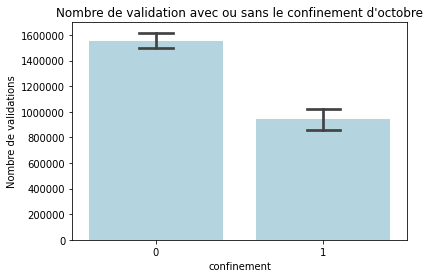

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_plt1 = (validations_ddf
 .groupby('jour', 'confinement')
 .agg(F.sum('nb_vald').alias('Nombre de validations'))).toPandas()
 
plt1 = sns.barplot(x="confinement", y="Nombre de validations", data=df_plt1, estimator=np.mean, ci=85, capsize=.2, color='lightblue')
plt1.set_title("Nombre de validation avec ou sans le confinement d'octobre")
plt1.ticklabel_format(style='plain', axis='y')
plt.show()

<font color='red'>***Lors de l'annonce du confinement, certaines lignes de transport ont été fermées. Le graphique suivant décrit le nombre de lignes en activités par semaine. La semaine 1 correspond à la première semaine de la base de données. Nous observons que lors du confinement, le nombre de lignes de transport en activité est passé de 700 à moins de 400.***

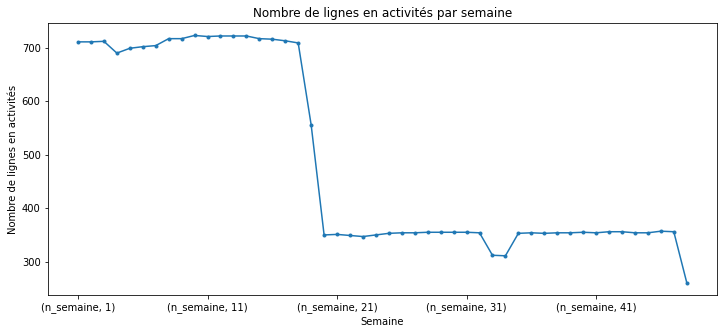

In [ ]:
(validations_ddf
 .withColumn('semaine', F.weekofyear(F.col('jour')) - 26)
 .withColumn('semaine_reformat', F.when(F.col('semaine') < 0, F.col('semaine') + 52).otherwise(F.col('semaine')))
 .groupby('semaine_reformat')
 .agg(F.count_distinct('code_stif_arret').alias('n_semaine'))
 .sort('semaine_reformat')).toPandas().set_index(['semaine_reformat']).unstack(1).plot(figsize=(12, 5),
                                                                                       title = "Nombre de lignes en activités par semaine",
                                                                                       ylabel = 'Nombre de lignes en activités',
                                                                                       xlabel = 'Semaine',
                                                                                       style='.-')

#### Bonus

Calculer la moyenne glissante sur 7 jours par categorie de titre pour réduire les variations hebdomadaires.

<font color='red'>***Pour calculer la moyenne glissante sur 7 jours, j'utilise la fonction analytique Window.***

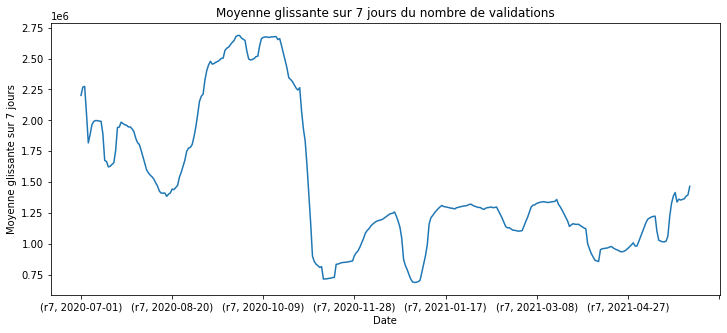

In [ ]:
agg_window = Window.orderBy('jour').rowsBetween(-6,0)

(validations_ddf
 .groupby('jour')
 .agg(F.sum('nb_vald').alias('nb_vald'))
 .withColumn('r7', F.mean('nb_vald').over(agg_window))
 .select('jour', 'r7')).toPandas().set_index(['jour']).unstack(1).plot(figsize=(12, 5),
                                                                               title = 'Moyenne glissante sur 7 jours du nombre de validations',
                                                                               ylabel = 'Moyenne glissante sur 7 jours',
                                                                               xlabel = "Date")

## Modélisation avec Apache Spark

On essaie de faire un modèle basique de prévision du trafic dans les 7 prochains jours, pour une station.

Apache Spark MLlib n'intègre pas de modèle pour les séries chronologiques.

L'approche classique est alors d'utiliser une technique de régression classique (régression linéaire bien sûr, mais aussi RandomForestRegressor par exemple).

Pour une première version simple, utiliser un vecteur constituer des validations sur les 14 jours précédents (X) pour prédire les validations du jour (y). Dans cette version, on utilisera une `LinearRegression` ou un `RandomForestRegressor`, au choix.

Le code doit comporter :
- la préparation des _features_ (X)
- la constitution d'un ensemble d'apprentissage et de test
- l'entrainement d'un modèle
- le mesure de la performance du modèle : RMSE

Rappel : ne travailler que sur les deux catégories de titre principales.


<font color='red'>***Avant tout, vous pouvez voir sur le tableau suivant qu'il semble y avoir des valeurs manquantes pour la journée du 31 mai 2021 car la ligne 306 (code_stif_arret) n'est pas référencée. Cette erreur de mesure peut impacter notre modèle, je décide donc de supprimer la journée du 31 mai 2021. (Aucun autre problème de ce type n'est à constater).***

In [ ]:
(validations_ddf
 .filter((F.col('libelle_arret') == "GARE DE LYON") & (F.col('jour') > '2021-05-27'))).show(20)

+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+-----------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|libelle_arret|id_refa_lda|categorie_titre|nb_vald|confinement|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+-----------+
|2021-05-28|           100|          110|            317| GARE DE LYON|      73626|         NAVIGO|   8385|          0|
|2021-05-28|           100|          110|            317| GARE DE LYON|      73626|      IMAGINE R|   2675|          0|
|2021-05-28|           810|          801|            306| GARE DE LYON|      73626|      IMAGINE R|   2827|          0|
|2021-05-28|           810|          801|            306| GARE DE LYON|      73626|         NAVIGO|   7454|          0|
|2021-05-29|           810|          801|            306| GARE DE LYON|      73626|      IMAGINE R|   2880|          0|
|2021-05-29|           810|          801

In [ ]:
validations_ddf = validations_ddf.filter(F.col('jour') != '2021-05-31')

<font color='red'>***Comme les prédictions doivent se faire sur une seule station, je choisis d'étudier la Gare de Lyon. Le code suivant permet de créer les variables lag pour les 14 derniers jours.***

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id 

agg_window = Window.orderBy('jour').rowsBetween(-15,-1)

df1 = (validations_ddf
        .filter(F.col('libelle_arret') == "GARE DE LYON")
        .groupby('jour')
        .agg(F.sum('nb_vald').alias('nb_vald'))
        .orderBy('jour')
        .withColumn('rolling14', F.mean('nb_vald').over(agg_window)))

df1 = df1.filter(monotonically_increasing_id() >= 14) # Suppression des 14 premiers jours de la base de données

df1.show(5)

+----------+-------+------------------+
|      jour|nb_vald|         rolling14|
+----------+-------+------------------+
|2020-07-15|  28446|           23005.5|
|2020-07-16|  23861|           23368.2|
|2020-07-17|  26863|           23279.6|
|2020-07-18|  24656|           23370.0|
|2020-07-19|  24930|23356.866666666665|
+----------+-------+------------------+
only showing top 5 rows



<font color='red'>***Préparation des features et constitution des échantillons d'apprentissage / de test.***

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

vector = VectorAssembler(inputCols = ['rolling14'], outputCol = 'features')

df2 = vector.transform(df1).select(['features', 'nb_vald'])
df2.show(5)

+--------------------+-------+
|            features|nb_vald|
+--------------------+-------+
|           [23005.5]|  28446|
|           [23368.2]|  23861|
|           [23279.6]|  26863|
|           [23370.0]|  24656|
|[23356.866666666665]|  24930|
+--------------------+-------+
only showing top 5 rows



In [ ]:
splits = df2.randomSplit([0.7, 0.3], seed = 123)
train_df = splits[0]
test_df = splits[1]

<font color='red'>***Entraînement du modèle :***

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='nb_vald', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

<font color='red'>***Évaluation du modèle : On obtient un RMSE de 4177***

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lr_model.transform(test_df)
lr_evaluator = RegressionEvaluator(labelCol="nb_vald", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) sur l'échantillon test = %g" % rmse)

Root Mean Squared Error (RMSE) sur l'échantillon test = 4177.15


## Amélioration du modèle

Discuter des façons d'améliorer cette première version du modèle.

---
🔽 <font color='red'>***Mes suggestions d'amélioration du modèle sont les suivantes :***
<font color='red'>
*   ***Ajouter la variable "confinement"***
*   ***Ajouter une variable indiquant si l'observation est en période de vacances***
*   ***Ajouter une variable indiquant si l'observation a lieu un jour férié***
*   ***Ajouter la variable représentant le jour de la semaine (car nous avons vu des différences le week-end).***
*   ***Ajouter une variable temporelle représentant le nombre de jours entre celui de l'observation et le premier jour de la base de données. Cela permettra de prendre en compte la tendance.***
</font>

<font color='red'>***Ensuite, une façon d'améliorer le modèle est également d'analyser les résidus. C'est-à-dire d'observer dans quels cas notre modèle se trompe "beaucoup" et chercher les variables ommises.***

<font color='red'>***Enfin, les paramètres du modèle peuvent être améliorés par validation croisée.***

---










## OPTION : implémentation des améliorations

Implémenter tout ou partir des suggestions d'amélioration.

Cette partie est facultative et sera bonifiante si les éléments contribués sont probants.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd

<font color='red'>***Le code suivant permet de créer deux objets, `feries` et `holidays`, contenant respectivement les jours fériés et les vacances sur la période concernée.***



In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
feries = ['2020-07-14', '2020-08-15', '2020-11-01', '2020-11-11', '2020-12-25', '2021-01-01', '2021-04-05', '2021-05-01', '2021-05-08', '2021-05-13', '2021-05-24']

holidays = [pd.date_range('2020-07-04', '2020-08-31').format(),
 pd.date_range('2020-10-17', '2020-11-01').format(),
 pd.date_range('2020-12-19', '2021-01-03').format(),
 pd.date_range('2021-02-13', '2021-02-28').format(),
 pd.date_range('2021-04-10', '2021-04-25').format()]

holidays = flatten(holidays)


<font color='red'>***Comme évoqué précédemment, j'ajoute les variables représentant le confinement, jour de la semaine, le temps, les jours fériés et les vacances.***

In [ ]:
from pyspark.sql.functions import datediff, to_date

df1 = (validations_ddf
        .filter(F.col('libelle_arret') == "GARE DE LYON")
        .groupby('jour', 'confinement')
        .agg(F.sum('nb_vald').alias('nb_vald'))
        .orderBy('jour')
        .withColumn('rolling14', F.mean('nb_vald').over(agg_window)))

df1 = (df1
 .withColumn('weekday', F.dayofweek('jour'))
 .withColumn('day', datediff(col("jour"), to_date(lit("2020-07-01"))))
 .withColumn('feries', F.when(F.col('jour').isin(feries), 1).otherwise(0))
 .withColumn('holidays', F.when(F.col('jour').isin(holidays), 1).otherwise(0)))

ohe_weekday = OneHotEncoder(inputCol="weekday", outputCol="ohe_weekday")
df1 = ohe_weekday.fit(df1).transform(df1)

df1 = df1.filter(monotonically_increasing_id() >= 14)

df1.show(10)

+----------+-----------+-------+------------------+-------+---+------+--------+-------------+
|      jour|confinement|nb_vald|         rolling14|weekday|day|feries|holidays|  ohe_weekday|
+----------+-----------+-------+------------------+-------+---+------+--------+-------------+
|2020-07-15|          0|  28446|           23005.5|      4| 14|     0|       1|(7,[4],[1.0])|
|2020-07-16|          0|  23861|           23368.2|      5| 15|     0|       1|(7,[5],[1.0])|
|2020-07-17|          0|  26863|           23279.6|      6| 16|     0|       1|(7,[6],[1.0])|
|2020-07-18|          0|  24656|           23370.0|      7| 17|     0|       1|    (7,[],[])|
|2020-07-19|          0|  24930|23356.866666666665|      1| 18|     0|       1|(7,[1],[1.0])|
|2020-07-20|          0|  27209|           24010.8|      2| 19|     0|       1|(7,[2],[1.0])|
|2020-07-21|          0|  27166|           24835.0|      3| 20|     0|       1|(7,[3],[1.0])|
|2020-07-22|          0|  26453|24869.333333333332|      4| 

In [ ]:
splits = df1.randomSplit([0.7, 0.3], seed = 123)
train_df = splits[0]
test_df = splits[1]

In [ ]:
vector = VectorAssembler(inputCols = ['confinement', 'rolling14', 'day', 'feries', 'holidays', 'ohe_weekday'], outputCol = 'features')

train_df2 = vector.transform(train_df).select(['features', 'nb_vald'])
test_df2 = vector.transform(test_df).select(['features', 'nb_vald'])

<font color='red'>***L'ajout de ces différentes variables nous permet de faire passer le RMSE de 4177 à 2512 sur l'échantillon test.***

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='nb_vald', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df2)
lr_predictions = lr_model.transform(test_df2)
lr_evaluator = RegressionEvaluator(labelCol="nb_vald", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2512.11


<font color='red'>***Je vais désormais procéder à l'analyse des résidus. Pour cela, j'affiche les observations pour lesquelles le résidus sont les plus élevés afin de comprendre pourquoi le modèle se trompe.***

In [ ]:
df_res = (test_df
 .withColumn("id",monotonically_increasing_id())
 .drop('nb_vald')
 .join(lr_predictions.withColumn("id",monotonically_increasing_id()), on=["id"])
 .drop('features', 'id')
 .withColumn('res', F.abs(F.col('nb_vald') - F.col('prediction'))))

<font color='red'>***Sur le tableau suivant, on observe que 2 des observations pour lesquelles le modèle se trompe le plus sont des observations qui ont eu lieu au tout début du confinement : le modèle sur-estime le trafic. Cela est probablement dû au fait que la variable rolling14 est élevée pour ces observations puisqu'elle prend en compte les valeurs de nb_vald juste avant la fin du confinement. Pour remédier à ce problème, je vais créer une nouvelle variable représentant le nombre de jours passés depuis le début du confinement d'octobre. En plus de régler le problème évoqué précédemment, cette variable permettra également au modèle de prendre en compte la nouvelle tendance du trafic qui est née à partir du confinement d'octobre. En effet, comme nous le savons, la gouvernement n'a pas rendu la liberté à la population d'un seul coup, mais par étape avec le couvre-feu, l'ouverture des terasses, puis des restaurants, puis des boîtes de nuit. Ainsi, on peut penser que le trafic retrouvera son niveau d'avant la crise petit à petit (à travers une nouvelle tendance) et pas brusquement.***

<font color='red'>***On remarque également que plusieurs observations ayant un fort résidus se situent à la fin du mois de mai. Cette fois-ci, le modèle sous-évalue le trafic. Cela provient probablement de la décision prise le 19 mai 2021 de décaler le couvre-feu à 21h00, de réouvrir les terasses, les commerces, les musées ou encore les cinémas. Ainsi, je vais prendre en compte ce phénomène en créant une variable indicatrice de cette période.***

In [ ]:
(df_res.
 withColumn('day_week', F.dayofweek('jour'))
 .orderBy(col('res').desc())).show(20)

+----------+-----------+------------------+-------+---+------+--------+-------------+-------+------------------+------------------+--------+
|      jour|confinement|         rolling14|weekday|day|feries|holidays|  ohe_weekday|nb_vald|        prediction|               res|day_week|
+----------+-----------+------------------+-------+---+------+--------+-------------+-------+------------------+------------------+--------+
|2020-11-05|          1|           20075.8|      5|127|     0|       0|(7,[5],[1.0])|  11181|18100.429492950167| 6919.429492950167|       5|
|2021-05-25|          0|16979.533333333333|      3|328|     0|       0|(7,[3],[1.0])|  23991|17982.023662751653| 6008.976337248347|       3|
|2020-10-03|          0|28629.133333333335|      7| 94|     0|       0|    (7,[],[])|  17813| 23351.88285294855| 5538.882852948551|       7|
|2021-05-08|          0|13965.266666666666|      7|311|     1|       0|    (7,[],[])|   9568|4032.4652903679716| 5535.534709632028|       7|
|2020-10-31| 

<font color='red'>***Le code suivant applique les modifications citées précédemment.***

In [ ]:
df1 = (validations_ddf
        .filter(F.col('libelle_arret') == "GARE DE LYON")
        .groupby('jour', 'confinement')
        .agg(F.sum('nb_vald').alias('nb_vald'))
        .orderBy('jour')
        .withColumn('rolling14', F.mean('nb_vald').over(agg_window)))

df1 = (df1
 .withColumn('weekday', F.dayofweek('jour'))
 .withColumn('day', datediff(col("jour"), to_date(lit("2020-07-01"))))
 .withColumn('feries', F.when(F.col('jour').isin(feries), 1).otherwise(0))
 .withColumn('holidays', F.when(F.col('jour').isin(holidays), 1).otherwise(0))
 .withColumn('day_af_conf', F.when(F.col('jour') >= '2020-10-30', datediff(col("jour"), to_date(lit("2020-10-30")))).otherwise(0))
 .withColumn('deconf3', F.when(F.col('jour') >= '2021-05-19', 1).otherwise(0)))

ohe_weekday = OneHotEncoder(inputCol="weekday", outputCol="ohe_weekday")
df1 = ohe_weekday.fit(df1).transform(df1)

df1 = df1.filter(monotonically_increasing_id() >= 14)

df1.show(10)

+----------+-----------+-------+------------------+-------+---+------+--------+-----------+-------+-------------+
|      jour|confinement|nb_vald|         rolling14|weekday|day|feries|holidays|day_af_conf|deconf3|  ohe_weekday|
+----------+-----------+-------+------------------+-------+---+------+--------+-----------+-------+-------------+
|2020-07-15|          0|  28446|           23005.5|      4| 14|     0|       1|          0|      0|(7,[4],[1.0])|
|2020-07-16|          0|  23861|           23368.2|      5| 15|     0|       1|          0|      0|(7,[5],[1.0])|
|2020-07-17|          0|  26863|           23279.6|      6| 16|     0|       1|          0|      0|(7,[6],[1.0])|
|2020-07-18|          0|  24656|           23370.0|      7| 17|     0|       1|          0|      0|    (7,[],[])|
|2020-07-19|          0|  24930|23356.866666666665|      1| 18|     0|       1|          0|      0|(7,[1],[1.0])|
|2020-07-20|          0|  27209|           24010.8|      2| 19|     0|       1|         

In [ ]:
splits = df1.randomSplit([0.7, 0.3], seed = 123)
train_df = splits[0]
test_df = splits[1]

In [ ]:
vector = VectorAssembler(inputCols = ['confinement', 'rolling14', 'day', 'feries', 'holidays', 'ohe_weekday', 'day_af_conf', 'ohe_weekday', 'deconf3'], outputCol = 'features')

train_df2 = vector.transform(train_df).select(['features', 'nb_vald'])
test_df2 = vector.transform(test_df).select(['features', 'nb_vald'])

<font color='red'>***Ces améliorations nous permettent de faire passer le RMSE à 2405 sur l'échantillon test***

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='nb_vald', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df2)
lr_predictions = lr_model.transform(test_df2)
lr_evaluator = RegressionEvaluator(labelCol="nb_vald", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2405.37
